# <span style="color:lightblue"><center><b>CLASSIFICAÇÃO DOS ESTÁGIOS</b></center></span>

# **Regressão Logística**

### **Importação das Bibliotecas**

In [436]:
import pandas as pd # Manipulação de Tabelas
import numpy as np # Operações matemáticas
import matplotlib.pyplot as plt # Visualização de Dados
from matplotlib.colors import LinearSegmentedColormap # Manipulação de paletas de cores
from seaborn import heatmap # Mapa de Calor
from funcions import plot_boxplots # Função criada na EDA_numericos

In [437]:
# Leitura dos dados
df = pd.read_csv('../data/dados_processados/liver_cirrhosis_v2.csv')

In [438]:
# Separando as colunas categóricas
categoric_columns = df.select_dtypes(include=['object']).columns

In [439]:
df[categoric_columns].head()

,Sexo,Ascite,Hepatomegalia,Telangiectasia,Edema
0,F,N,S,N,N
1,M,S,N,S,N
2,F,N,N,N,N
3,F,N,N,N,N
4,F,N,S,N,N


In [440]:
# Trasnformando as classes em string para binário
colunas_binarias = {column:pd.factorize(df[column])[0] for column in df[categoric_columns].columns}

In [441]:
# Substituindo no DataFrame
df[categoric_columns] = pd.DataFrame(colunas_binarias)

In [442]:
# Convertendo idade em dias para anso
df['Idade'] = (df['Idade']/365).astype(int)
df['Idade']

0       50
1       54
2       32
3       45
4       59
        ..
9632    49
9633    64
9634    67
9635    58
9636    78
Name: Idade, Length: 9637, dtype: int32

In [443]:
df.head()

,Idade,Sexo,Ascite,Hepatomegalia,Telangiectasia,Edema,Bilirrubina(mg/dl),Colesterol(mg/dl),Albumina(gm/dl),Cobre_Urina(ug/dia),Fosfatase_Alcalina (U/L),Aspartato_Aminotransferase(U/L),Triglicerídeos(mg/dl),Plaquetas(ml/1000),Tempo_de_Protrombina(s),Estágio
0,50,0,0,0,0,0,0.5,149.0,4.04,227.0,598.0,52.70,57.0,256.0,9.9,1
1,54,1,1,1,1,0,0.5,219.0,3.93,22.0,663.0,45.00,75.0,220.0,10.8,2
2,32,0,0,1,0,0,0.5,320.0,3.54,51.0,1243.0,122.45,80.0,225.0,10.0,2
3,45,0,0,1,0,0,0.7,255.0,3.74,23.0,1024.0,77.50,58.0,151.0,10.2,2
4,59,0,0,0,0,0,1.9,486.0,3.54,74.0,1052.0,108.50,109.0,151.0,11.5,1


In [444]:
# Separando as colunas categóricas
numeric_columns = df.select_dtypes('number')

<Axes: >

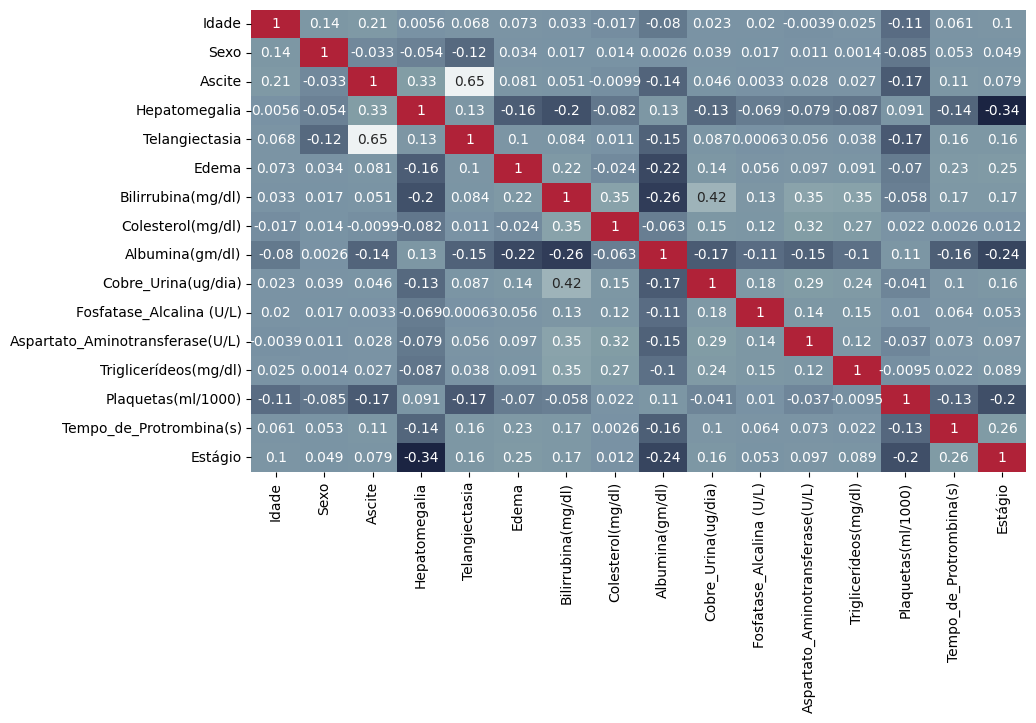

In [445]:
# Mapa de calor com as correlações
colors = ["#1b2442","#7992a4","#829da5","#f4f7f7","#b02238"]
cmap = LinearSegmentedColormap.from_list("custom_palette", colors, N=256)
plt.figure(figsize=[10,6])
heatmap(df.corr(), 
    annot=True, # Escreve os valores dos coeficientes
    cmap=cmap, # Paleta de cores
    cbar=False
)

In [446]:
# Filtando os índices de correlção que possui o módulo > 0.10
mask = df.corr().abs() > 0.1
filtered = df.corr().where(mask)
filtered

,Idade,Sexo,Ascite,Hepatomegalia,Telangiectasia,Edema,Bilirrubina(mg/dl),Colesterol(mg/dl),Albumina(gm/dl),Cobre_Urina(ug/dia),Fosfatase_Alcalina (U/L),Aspartato_Aminotransferase(U/L),Triglicerídeos(mg/dl),Plaquetas(ml/1000),Tempo_de_Protrombina(s),Estágio
Idade,1.000000,0.138954,0.205923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.112695,NaN,NaN
Sexo,0.138954,1.000000,NaN,NaN,-0.124024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ascite,0.205923,NaN,1.000000,0.329621,0.649646,NaN,NaN,NaN,-0.143593,NaN,NaN,NaN,NaN,-0.169384,0.114120,NaN
Hepatomegalia,NaN,NaN,0.329621,1.000000,0.132154,-0.161125,-0.196951,NaN,0.134408,-0.125755,NaN,NaN,NaN,NaN,-0.135294,-0.336901
Telangiectasia,NaN,-0.124024,0.649646,0.132154,1.000000,0.100366,NaN,NaN,-0.146398,NaN,NaN,NaN,NaN,-0.171288,0.163029,0.155757
Edema,NaN,NaN,NaN,-0.161125,0.100366,1.000000,0.224647,NaN,-0.224724,0.139269,NaN,NaN,NaN,NaN,0.225660,0.254994
Bilirrubina(mg/dl),NaN,NaN,NaN,-0.196951,NaN,0.224647,1.000000,0.352127,-0.261299,0.415027,0.132425,0.352460,0.348504,NaN,0.170697,0.172219
Colesterol(mg/dl),NaN,NaN,NaN,NaN,NaN,NaN,0.352127,1.000000,NaN,0.145983,0.117626,0.322665,0.267340,NaN,NaN,NaN
Albumina(gm/dl),NaN,NaN,-0.143593,0.134408,-0.146398,-0.224724,-0.261299,NaN,1.000000,-0.168683,-0.112587,-0.147348,-0.103031,0.107514,-0.156307,-0.237199
Cobre_Urina(ug/dia),NaN,NaN,NaN,-0.125755,NaN,0.139269,0.415027,0.145983,-0.168683,1.000000,0.184010,0.285076,0.239766,NaN,0.101950,0.160070


<Axes: >

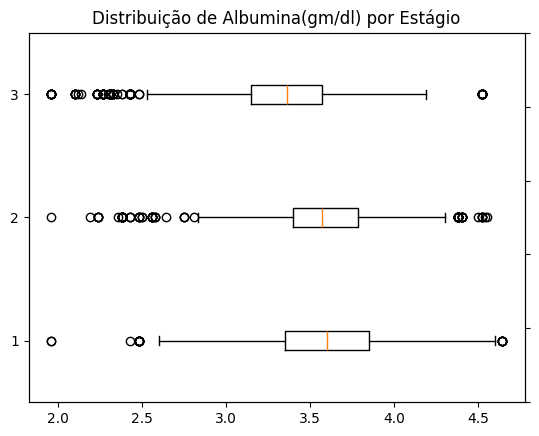

In [447]:
# Boxplots da Albumina por estágio
plot_boxplots(df=df, serie_categoria=df['Estágio'], serie_alvo=df['Albumina(gm/dl)'])

#### **Separação de Dados de Treino e Teste**

In [448]:
from sklearn.model_selection import train_test_split # Separação de dados de treino e teste
from sklearn.linear_model import LogisticRegression # Modelo de Regressão Logística
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay # Feedback do modelo, matriz de confusão
from sklearn.preprocessing import StandardScaler # Padronizador de Dados

In [449]:
X = df.drop(columns=['Estágio']).values # Dados preditores
Y = df['Estágio'].values # Alvo

In [450]:
# Separação de Dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [451]:
# Instanciando o padronizador
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train) # Padronizando os dados de treino
X_test_scaled = scaler.transform(X_test) # Padronizando os dados de teste

In [452]:
# Salvando o Scaler
import joblib
 
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

In [474]:
# Instanciando o classificador
classifier = LogisticRegression(max_iter=3000, n_jobs=-1)

In [475]:
# Treinando o modelo
classifier.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=3000, n_jobs=-1)

In [476]:
# Classe da predição
test_predict = classifier.predict(X_test_scaled)

In [477]:
# Feedback do modelo
print(classification_report(y_test,test_predict))

              precision    recall  f1-score   support

           1       0.47      0.53      0.50       753
           2       0.50      0.38      0.43       845
           3       0.63      0.73      0.68       812

    accuracy                           0.54      2410
   macro avg       0.54      0.54      0.54      2410
weighted avg       0.54      0.54      0.54      2410



In [481]:
# Importância das classes para o modelo
coefficients = classifier.coef_
feature_importance = pd.DataFrame(coefficients.T, index=df.drop('Estágio', axis=1).columns, columns=classifier.classes_)
print("Importância das Variáveis (Coeficientes):\n")
print(feature_importance)

Importância das Variáveis (Coeficientes):

                                        1         2         3
Idade                           -0.013926 -0.103590  0.117516
Sexo                            -0.039332  0.045740 -0.006408
Ascite                           0.007112 -0.154478  0.147366
Hepatomegalia                    0.454183  0.042190 -0.496374
Telangiectasia                  -0.184174  0.054969  0.129205
Edema                           -0.187952  0.008437  0.179515
Bilirrubina(mg/dl)               0.028021 -0.033534  0.005513
Colesterol(mg/dl)                0.016868  0.107272 -0.124141
Albumina(gm/dl)                  0.082413  0.185526 -0.267939
Cobre_Urina(ug/dia)             -0.113998  0.031290  0.082708
Fosfatase_Alcalina (U/L)         0.007018  0.006259 -0.013278
Aspartato_Aminotransferase(U/L) -0.062147  0.063972 -0.001825
Triglicerídeos(mg/dl)           -0.083769  0.021690  0.062079
Plaquetas(ml/1000)               0.184132 -0.015416 -0.168716
Tempo_de_Protrombina(s)    

Matriz de Confusão:
[[399 212 142]
 [326 317 202]
 [119 101 592]]


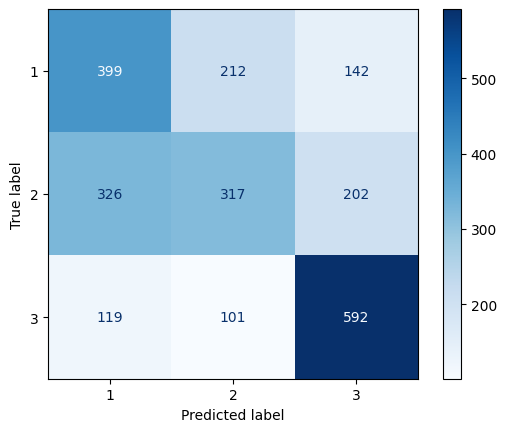

In [197]:
# Matriz de confusão
cm = confusion_matrix(y_test, test_predict)

print("Matriz de Confusão:")
print(cm)

# Visualizar a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [198]:
joblib.dump(classifier, 'classifier.joblib')

['classifier.joblib']

Potencias colunas a serem retiradas:
'Sexo','Fosfatase_Alcalina (U/L)','Aspartato_Aminotransferase(U/L)','Triglicerídeos(mg/dl)'

# **Árvore de Decisão**

In [199]:
from sklearn.tree import DecisionTreeClassifier, plot_tree # Modelo de Árvore de Decisão, plotagem da árvore

In [418]:
# Instanciando Árvore de decisão
arvore = DecisionTreeClassifier(
    random_state=42, 
    min_impurity_decrease=0.000091
    )

In [419]:
# Treinando o modelo
arvore.fit(X_train_scaled, y_train)

DecisionTreeClassifier(min_impurity_decrease=9.1e-05, random_state=42)

In [420]:
# Testando o modelo
arvore_predict = arvore.predict(X_test_scaled)

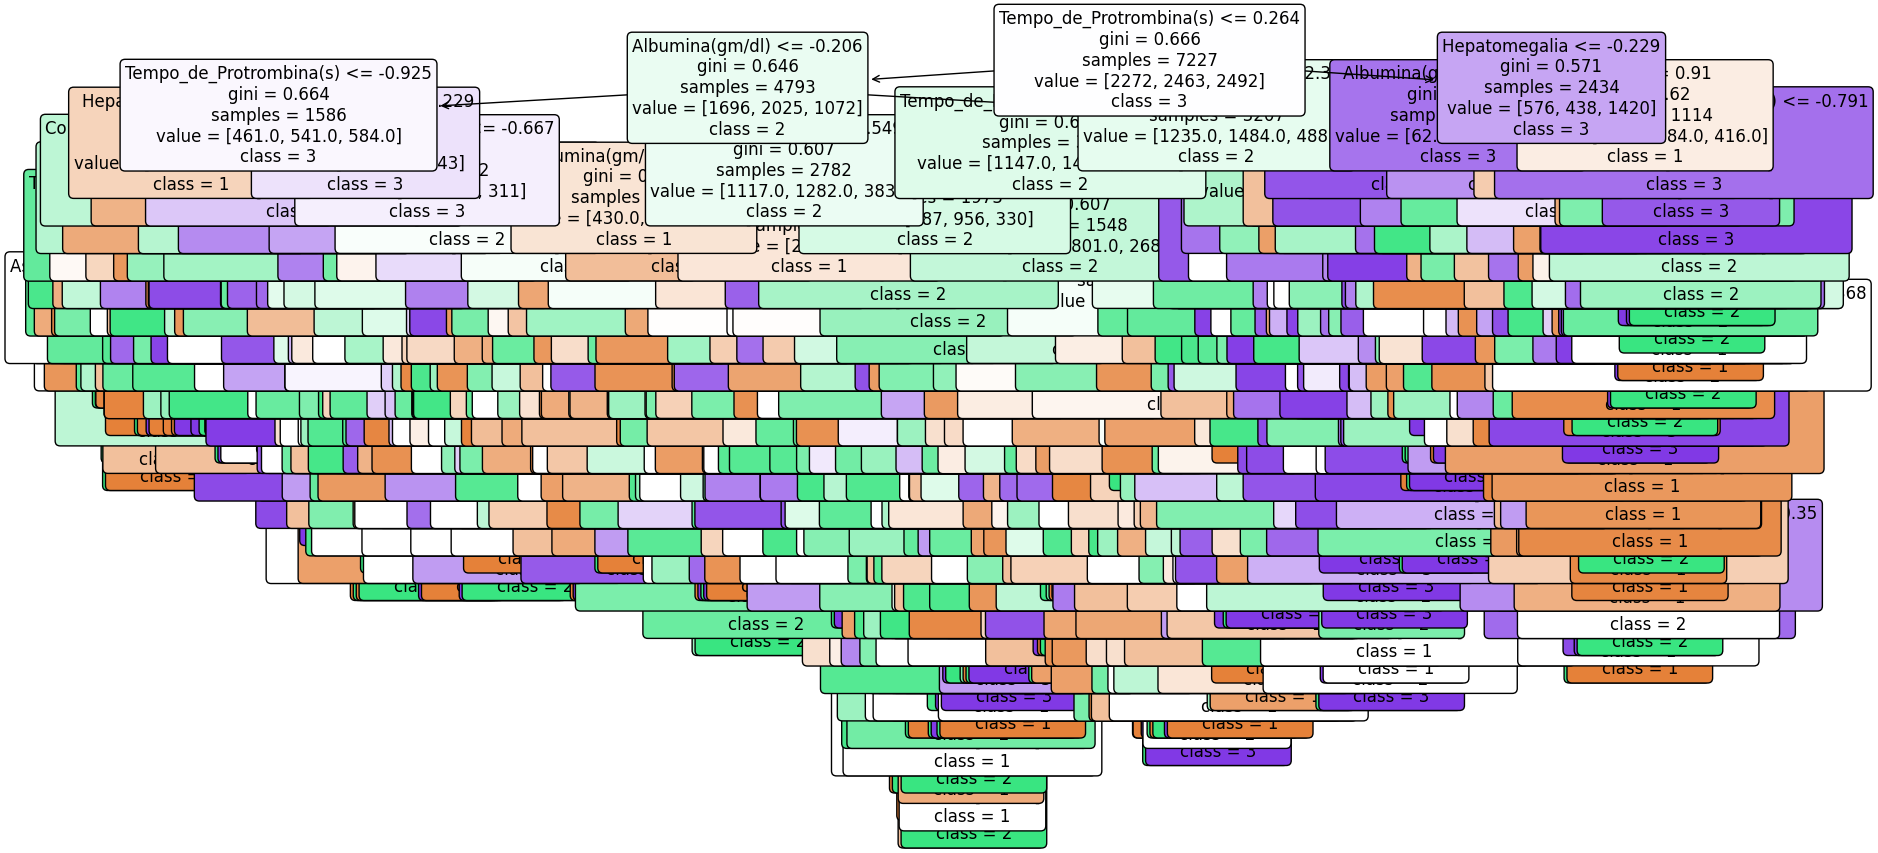

In [349]:
# Plotando a árvore
plt.figure(figsize=(20,10))  
plot_tree(
    arvore, 
    feature_names=df.drop(columns=['Estágio']).columns, 
    class_names=[str(cls) for cls in arvore.classes_], 
    filled=True, 
    rounded=True, 
    fontsize=12
    )
plt.show()

Devido a alta complexidade do modelo, a árvore acabou ficando com muitos nós.

In [435]:
# Feedback do modelo
print(classification_report(y_test,arvore_predict))

              precision    recall  f1-score   support

           1       0.74      0.77      0.76       753
           2       0.74      0.73      0.73       845
           3       0.82      0.80      0.81       812

    accuracy                           0.77      2410
   macro avg       0.77      0.77      0.77      2410
weighted avg       0.77      0.77      0.77      2410



Acurácia de 77%

#### **Utilizando o Minimal Cost Complexity Pruning**

In [422]:
from sklearn.model_selection import GridSearchCV

In [423]:
arvore_teste = DecisionTreeClassifier()

In [424]:
path = arvore_teste.cost_complexity_pruning_path(X_train_scaled, y_train)

In [425]:
param_grid = {'ccp_alpha': path.ccp_alphas}

CV_clf = GridSearchCV(estimator=arvore, param_grid=param_grid, cv = 7, verbose=2, n_jobs=-1)
CV_clf.fit(X_train, y_train)

Fitting 7 folds for each of 899 candidates, totalling 6293 fits


GridSearchCV(cv=7,
             estimator=DecisionTreeClassifier(min_impurity_decrease=9.1e-05,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'ccp_alpha': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.30616669e-05, 2.30616669e-05, 2.30616669e-05, 2.30616669e-05,
       2.30616669e-05, 2.63561907e-05, 2.64530885e-05, 2.83213453e-05,
       2.88270836e-05, 2.96507146e-05, 2...
       2.40708472e-03, 2.42738264e-03, 2.60520494e-03, 2.74225098e-03,
       2.78840814e-03, 2.78886448e-03, 2.82602835e-03, 3.05443502e-03,
       3.20874567e-03, 3.21457235e-03, 3.39128034e-03, 3.83877106e-03,
       3.96879538e-03, 4.01808314e-03, 5.83488791e-03, 5.85936215e-03,
       6.26356586e-03, 7.19093135e-03, 8.49958201e-03, 1.03358069e-02,
       1.29237118e-02, 2.69511693e-02, 4.51141826e-02])},
             verbose=2)

In [426]:
# Atribuindo o ccp_aplha
ccp_alpha = CV_clf.best_estimator_.ccp_alpha

In [427]:
# Instanciando uma nova árvore com o ccp_alpha
arvore_2 = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha,min_impurity_decrease=0.000091)

In [428]:
arvore_2.fit(X_train_scaled, y_train)

DecisionTreeClassifier(ccp_alpha=0.00015610974515084105,
                       min_impurity_decrease=9.1e-05, random_state=42)

In [429]:
arvore_2_predict = arvore_2.predict(X_test_scaled)

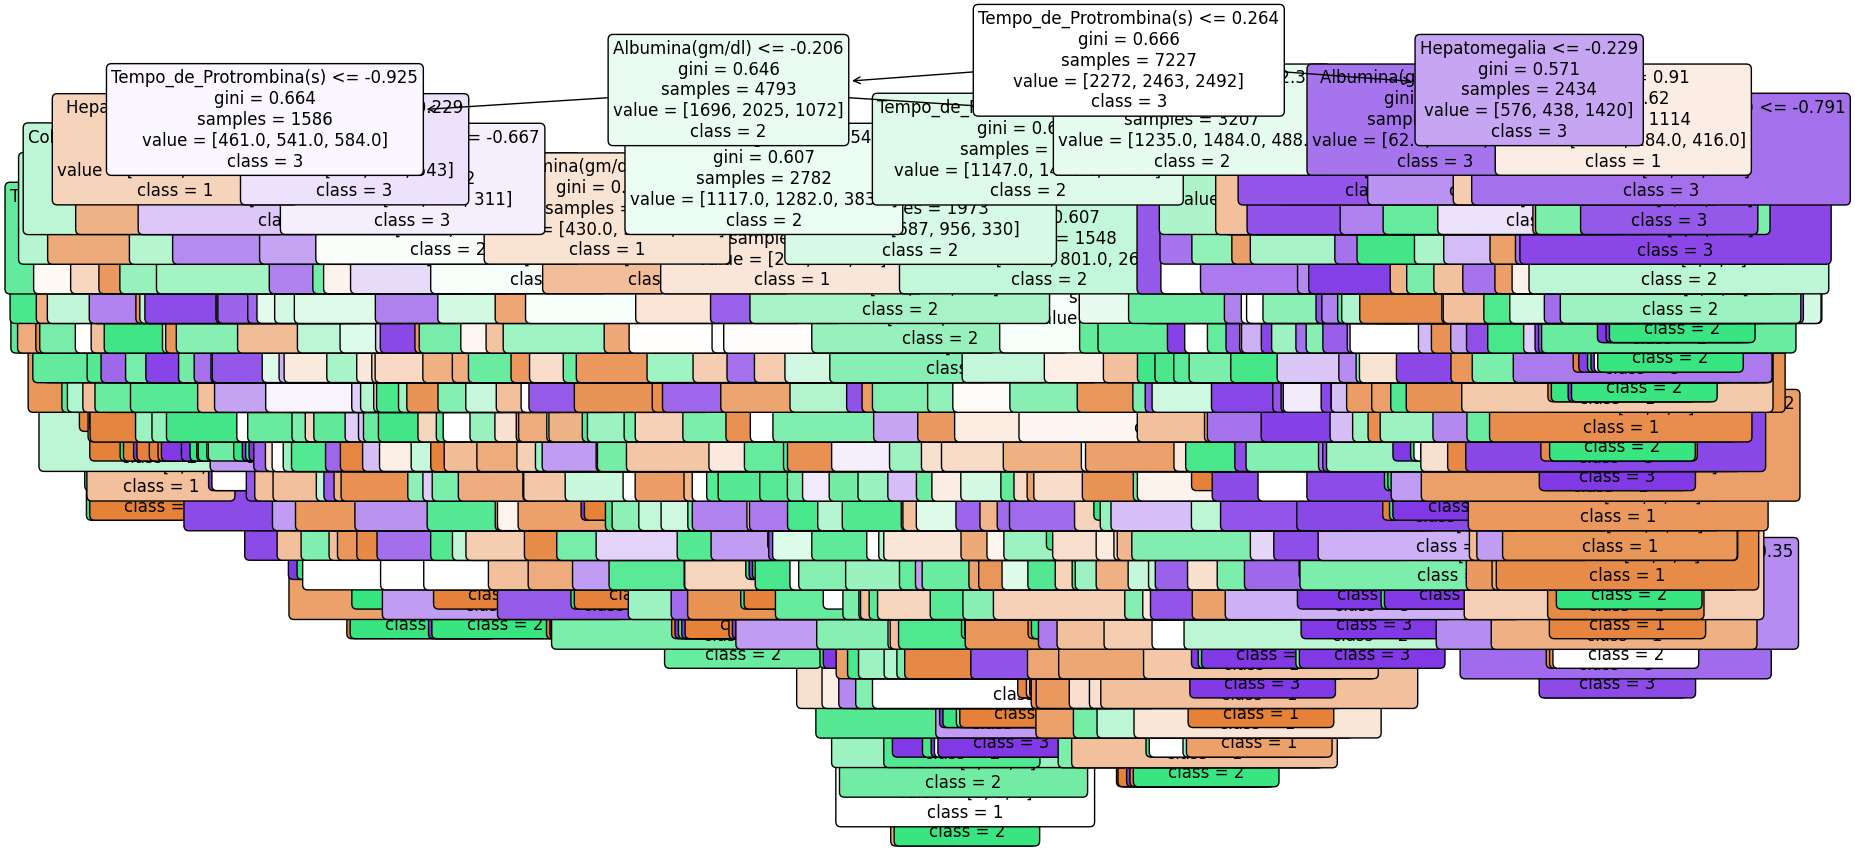

In [431]:
# Plotando a árvore
plt.figure(figsize=(20,10))  
plot_tree(
    arvore_2, 
    feature_names=df.drop(columns=['Estágio']).columns, 
    class_names=[str(cls) for cls in arvore_2.classes_], 
    filled=True, 
    rounded=True, 
    fontsize=12
    )
plt.show()

In [430]:
print(classification_report(y_test, arvore_2_predict))

              precision    recall  f1-score   support

           1       0.73      0.77      0.75       753
           2       0.74      0.73      0.73       845
           3       0.83      0.80      0.81       812

    accuracy                           0.77      2410
   macro avg       0.77      0.77      0.77      2410
weighted avg       0.77      0.77      0.77      2410



Acurácia de 77%

In [480]:
# Obter a importância das variáveis
importances = arvore_2.feature_importances_
feature_importance = pd.DataFrame(importances, index=df.drop('Estágio', axis=1).columns, columns=['Importance']).sort_values(by='Importance', ascending=False)

print("Importância das Variáveis:\n")
print(feature_importance)

Importância das Variáveis:

                                 Importance
Tempo_de_Protrombina(s)            0.191470
Albumina(gm/dl)                    0.151827
Plaquetas(ml/1000)                 0.126910
Idade                              0.094946
Bilirrubina(mg/dl)                 0.074808
Hepatomegalia                      0.065131
Cobre_Urina(ug/dia)                0.051084
Aspartato_Aminotransferase(U/L)    0.044216
Triglicerídeos(mg/dl)              0.040771
Colesterol(mg/dl)                  0.040409
Fosfatase_Alcalina (U/L)           0.039957
Edema                              0.033297
Telangiectasia                     0.023783
Ascite                             0.016762
Sexo                               0.004631
